In [1]:
import pandas as pd
import numpy as np
from ipynb.fs.defs.Preprocessing_Module import read_data, add_topological, add_landcover, select_columns, reshape_dataset, fillna_dataset
from ipynb.fs.defs.Feature_Expansion_Module import feature_expansion
from ipynb.fs.defs.Initializer_Module import initializer
from ipynb.fs.defs.XGBoost_Model_Module import Xgboost_model
from ipynb.fs.defs.Model_Validation_Module import test_model_random_split, train_model_KFold, operational_validation, predict

In [2]:
import warnings
warnings.filterwarnings('ignore')
np.set_printoptions(suppress=True)

In [3]:
data = read_data('../Datasets/Italy/Trentino/Anopheles/IT_trentino_anopheles_2011_2022.csv')
columns = ['dt_placement', 'x', 'y', 'anopheles_total', 'ndvi', 'ndwi', 'ndmi', 'ndbi',
           'ndvi_mean', 'ndvi_std', 'ndwi_mean', 'ndwi_std', 'ndmi_mean',
           'ndmi_std', 'ndbi_mean', 'ndbi_std', 'lst_day', 'lst_night',
           'acc_rainfall_1week', 'acc_rainfall_2week', 'acc_rainfall_jan',
           'lst_jan_day_mean', 'lst_feb_day_mean', 'lst_mar_day_mean', 'lst_apr_day_mean',
           'lst_jan_night_mean', 'lst_feb_night_mean', 'lst_mar_night_mean', 'lst_apr_night_mean','sex']
names = ['dt_placement', 'x', 'y', 'mosq_now', 'ndvi', 'ndwi', 'ndmi', 'ndbi',
         'ndvi_mean', 'ndvi_std', 'ndwi_mean', 'ndwi_std', 'ndmi_mean',
         'ndmi_std', 'ndbi_mean', 'ndbi_std', 'lst_day', 'lst_night',
         'acc_rainfall_1week', 'acc_rainfall_2week', 'acc_rainfall_jan',
         'lst_jan_day_mean', 'lst_feb_day_mean', 'lst_mar_day_mean', 'lst_apr_day_mean',
         'lst_jan_night_mean', 'lst_feb_night_mean', 'lst_mar_night_mean', 'lst_apr_night_mean','sex']
data = select_columns(data,columns,names)
data = add_topological(data,'../Datasets/Topological Datasets/2x2grid/Italy_trentino_2km_geo.csv')
data = add_landcover(data,'../Datasets/Landcover Datasets/2x2grid/Italy_trentino_2km_lulc.csv')
data = reshape_dataset(data,['x','y','dt_placement','sex'])
data = fillna_dataset(data,{'acc_rainfall_1week':0, 'acc_rainfall_2week':0, 'acc_rainfall_jan':0})
del data['sex']
#=====================removal of stations with only zero mosquitoes=====================================
st = data[['x', 'y']].drop_duplicates().reset_index(drop=True)
drop_index = []
for i in range(len(st)):
    cc = data.loc[(data['x']==st.loc[i,'x']) & (data['y']==st.loc[i,'y'])].dropna(subset=['mosq_now'])
    if len(cc['mosq_now'].unique())==1:
        drop_index.append(i)
st = st.drop(drop_index).reset_index(drop=True)
data = pd.merge(data, st, how='inner', on = ['x','y']).reset_index(drop=True)

Index(['station_id', 'y', 'x', 'dt_placement', 'week', 'month', 'year',
       'country_code', 'nuts0_code', 'nuts0_name', 'nuts1_code', 'nuts1_name',
       'nuts2_code', 'nuts2_name', 'nuts3_code', 'nuts3_name',
       'lau1_municipality', 'lau2_settlement', 'trap_type',
       'anopheles plumbeus', 'anopheles maculipennis sl', 'anopheles sp',
       'anopheles claviger', 'sex', 'anopheles_total', 'region',
       'dt_placement_original', 'indices_image_date', 'indices_lat',
       'indices_lon', 'ndvi', 'ndmi', 'ndwi', 'ndbi', 'ndvi_mean', 'ndmi_mean',
       'ndwi_mean', 'ndbi_mean', 'ndvi_std', 'ndmi_std', 'ndwi_std',
       'ndbi_std', 'lst_image_date', 'lst_lat', 'lst_lon', 'lst_day',
       'lst_night', 'monthly_lst_lat', 'monthly_lst_lon', 'lst_jan_day_mean',
       'lst_jan_night_mean', 'lst_feb_day_mean', 'lst_feb_night_mean',
       'lst_mar_day_mean', 'lst_mar_night_mean', 'lst_apr_day_mean',
       'lst_apr_night_mean', 'indices_image_date.1', 'indices_lat.1',
       'ind

In [4]:
# set the only_env as True if you want to use only environmental features
only_env = True
# set the case title
case_title = 'Anopheles Trentino'
# set the exp as True if you want to save the results as csv
exp = False
# set the filepath to export the data
path = '../Resuts/Culex Italy/'
# set the name of the date column
date_col = 'dt_placement'
# set the model type. Could be 'class_regression' or 'mosquito_regression' or 'classification'
model_type = 'class_regression'
# set the transform argument as True if you want to limit the target variable to 0-9 scale
transform_target = False
#set the data for embeddings e.g. data[['col', 'col2']]
embedded_data = None
#set the transformation actions of the data. Options are 'augmentation', 'normalization', 'log', 'scaling'
transformation_list = []

In [5]:
data = feature_expansion(data, env=only_env)

In [6]:
data = initializer(data, model_type, [-1, 1., 2., 3., 5., 8., 11., 14., 23., 40., np.inf], dropna=True)

Bounds: [-1.  1.  2.  3.  5.  8. 11. 14. 23. 40. inf]


In [7]:
model = Xgboost_model(model_type = model_type, learning_rate = 0.2,
                      embedding_data = embedded_data,  transformation_list = transformation_list,
                      early_stop = False, l1_weight = 1.5, l2_weight = 0, weights = False)

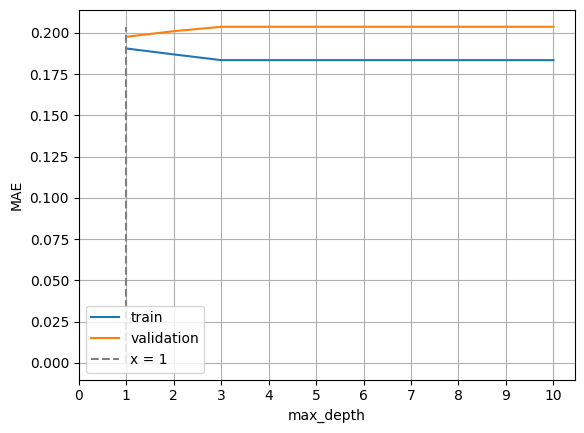

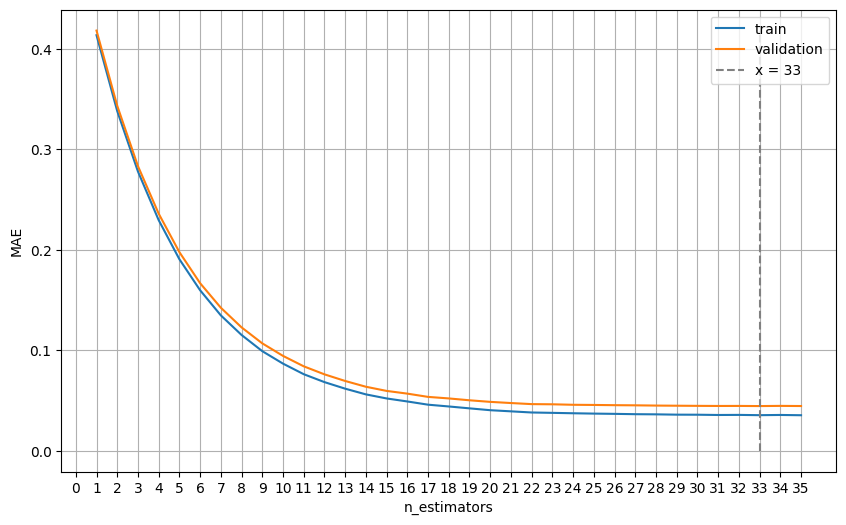

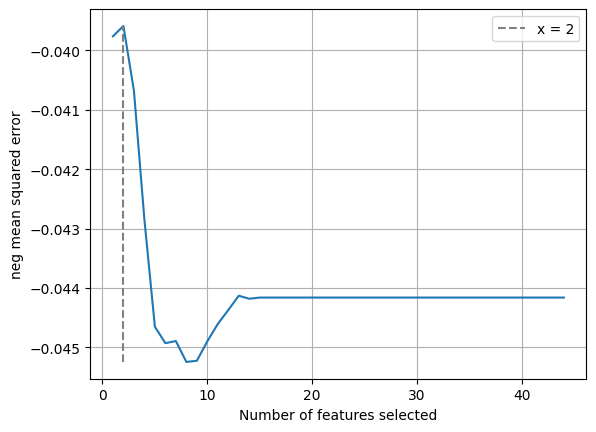

max_depth:  1
Number of estimators:  33
Selected_features:  Index(['lst_jan_day_mean', 'DISTANCE_TO_RIVER'], dtype='object')


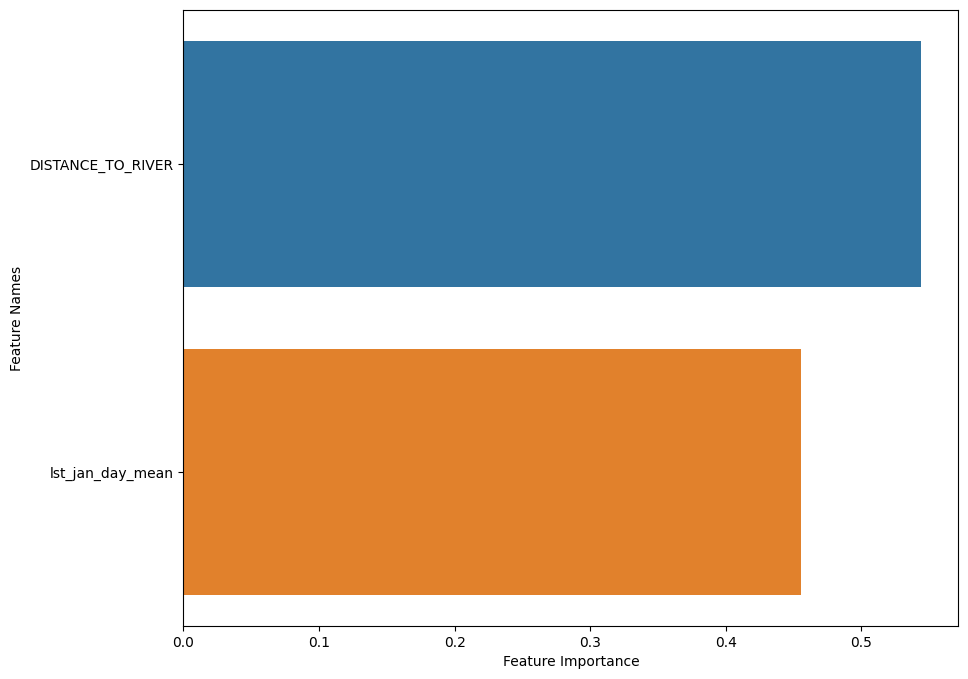

MAE on train set:  0.01973001038421599
min prediction: 0.0
max prediction: 0.0

MAE on test set:  0.02145922746781116
Error <= 3: 100.00 %
min prediction: 0.0
max prediction: 0.0


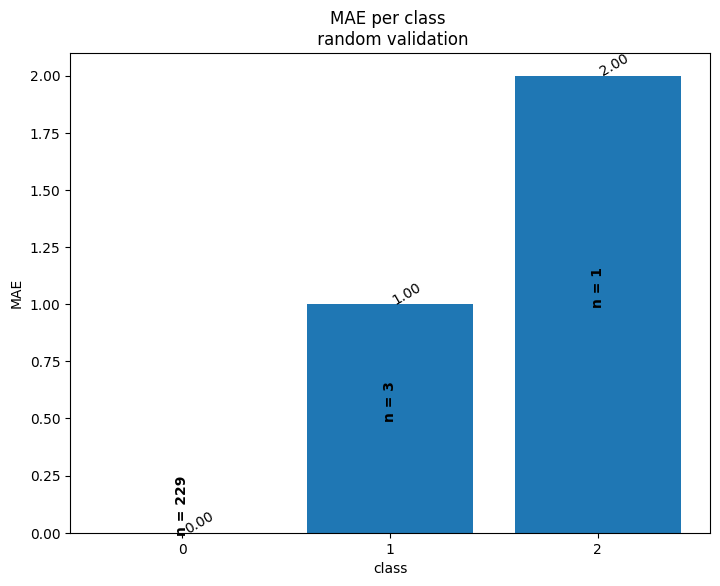

-----------|class error-MAE| difference-----------
mean: 1.0
std: 0.816496580927726
coefficient of variation (std/mean): 0.816496580927726

----------normalized difference-------------
mean: 0.5
std: 0.408248290463863
coefficient of variation (std/mean): 0.816496580927726


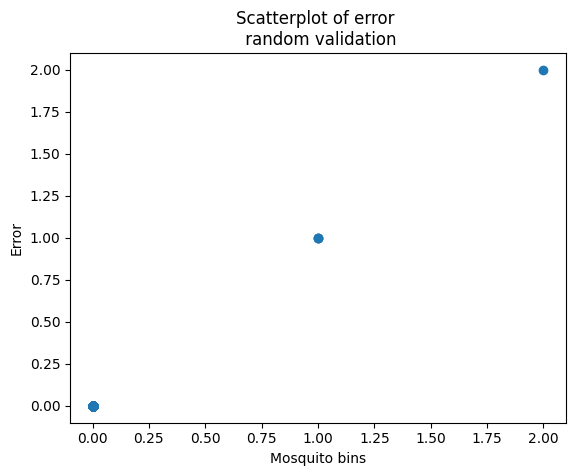

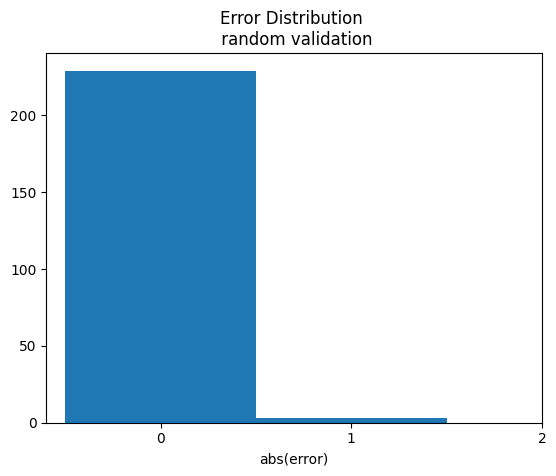

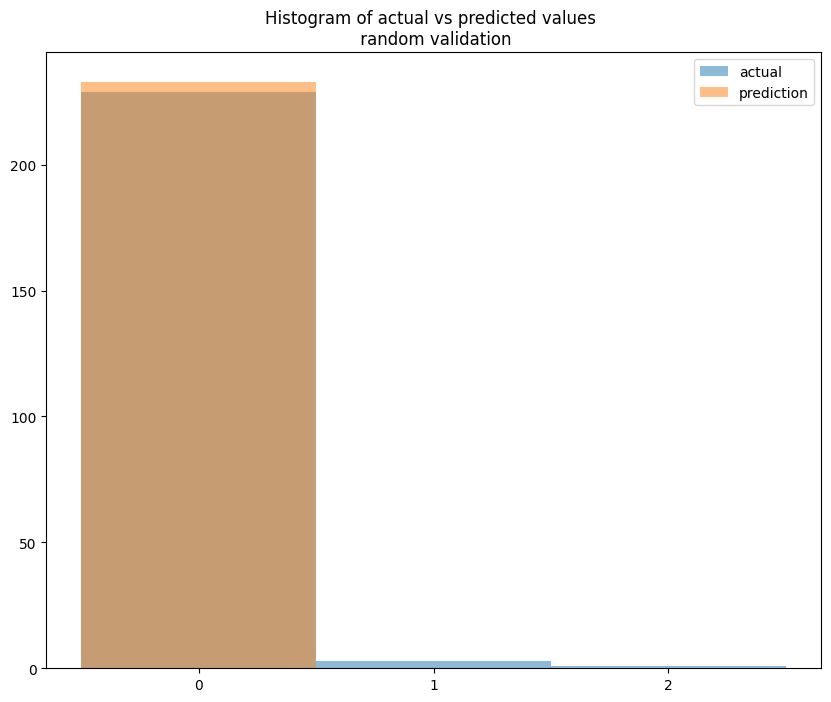

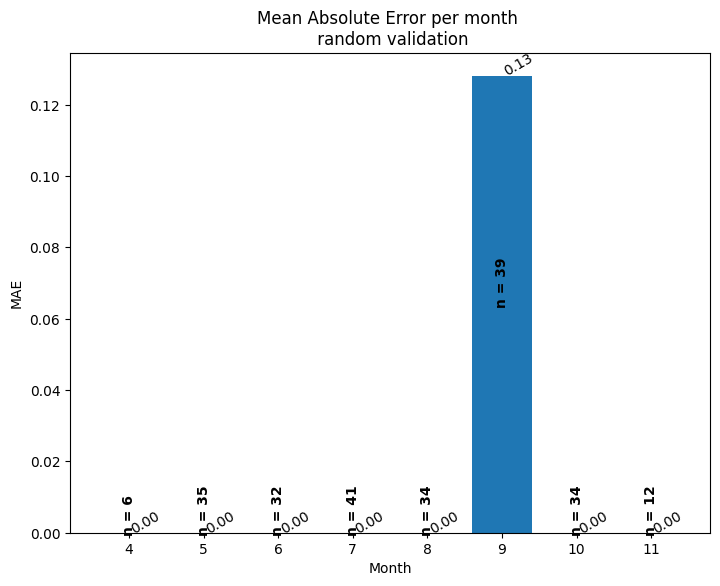

In [8]:
test_model_random_split(data, model, filepath = '', date_col = date_col, case='', fi = True, export=exp)

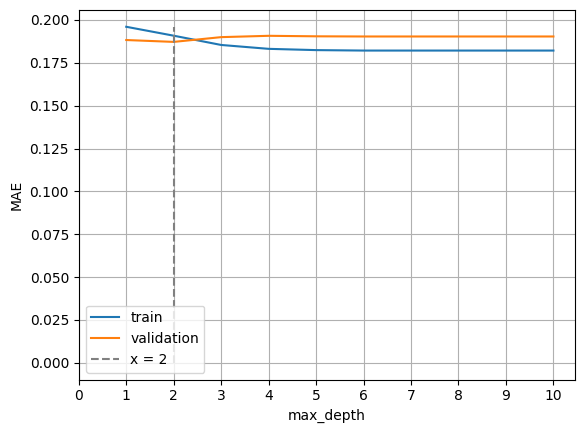

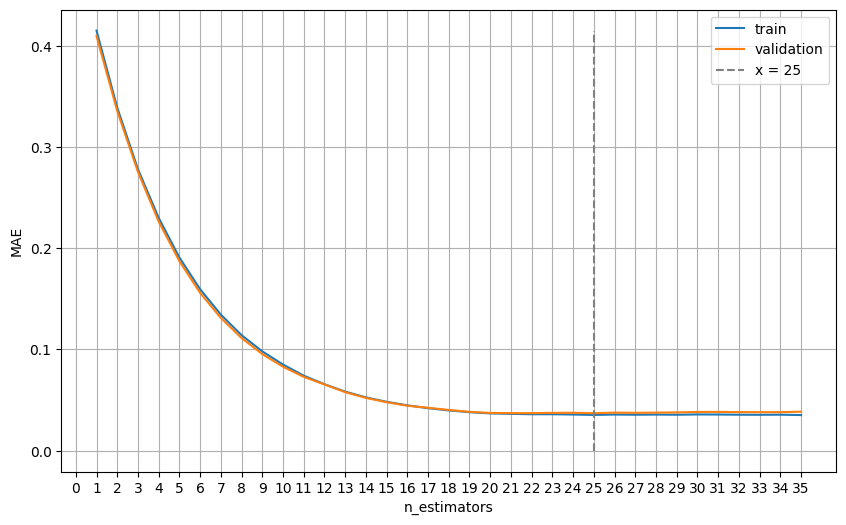

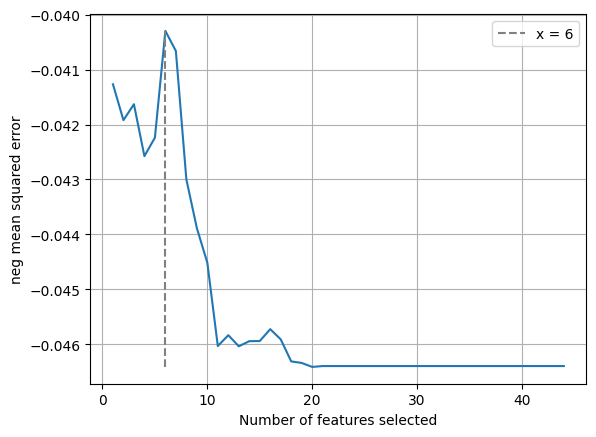

max_depth:  2
Number of estimators:  25
Selected_features:  Index(['ndvi', 'ndwi', 'acc_rainfall_jan', 'lst_jan_day_mean',
       'DISTANCE_TO_RIVER', 'days_distance'],
      dtype='object')
MAE on train set:  0.018439311852485506
min prediction: 0.0
max prediction: 1.0

MAE on test set:  0.02566295979469632
Error <= 3: 100.00 %
min prediction: 0.0
max prediction: 1.0


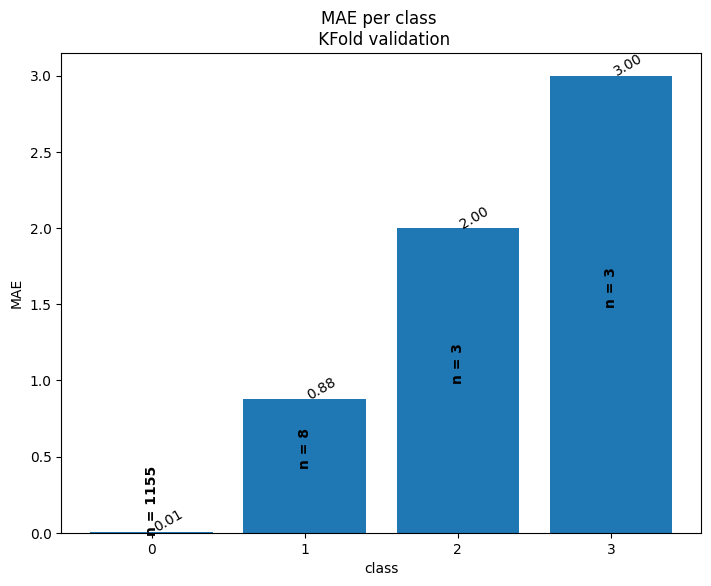

-----------|class error-MAE| difference-----------
mean: 1.5295183982683982
std: 1.1309739620111026
coefficient of variation (std/mean): 0.7394314205644753

----------normalized difference-------------
mean: 0.5110193086491177
std: 0.3778637333302931
coefficient of variation (std/mean): 0.7394314205644752


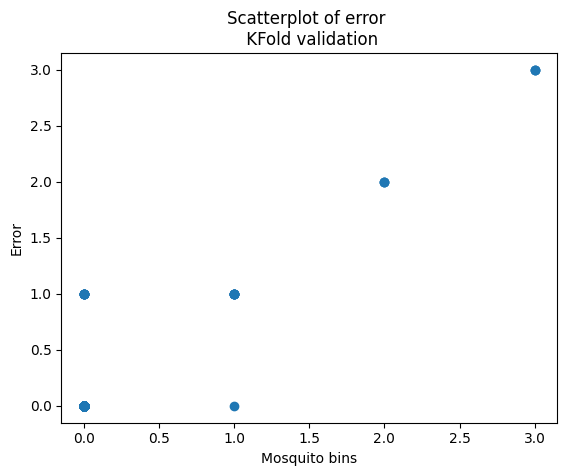

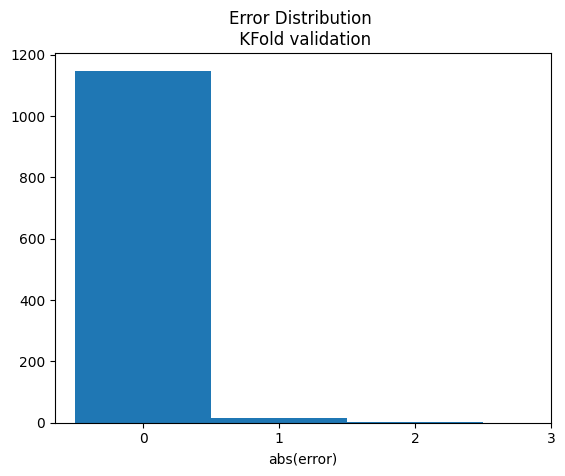

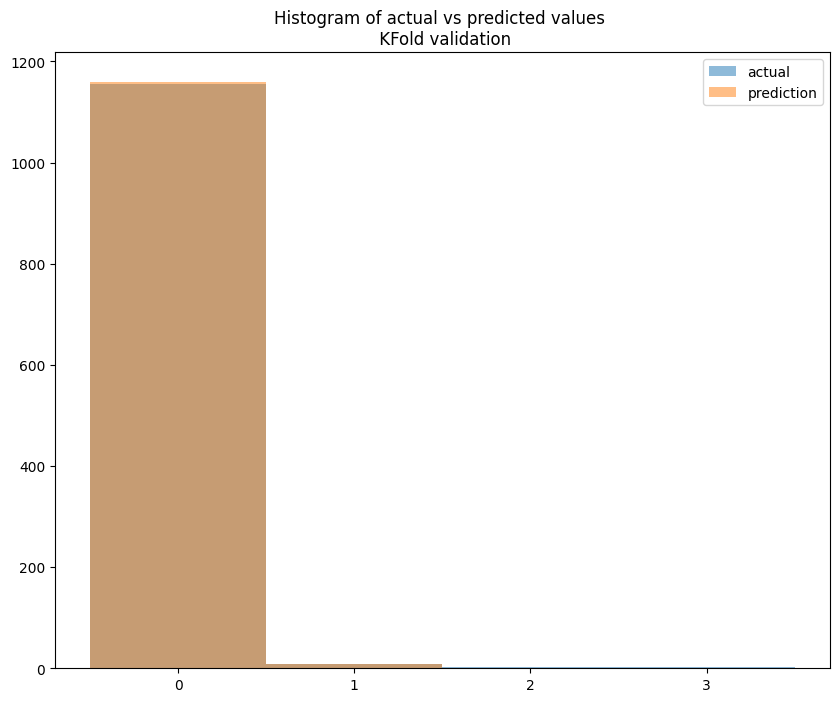

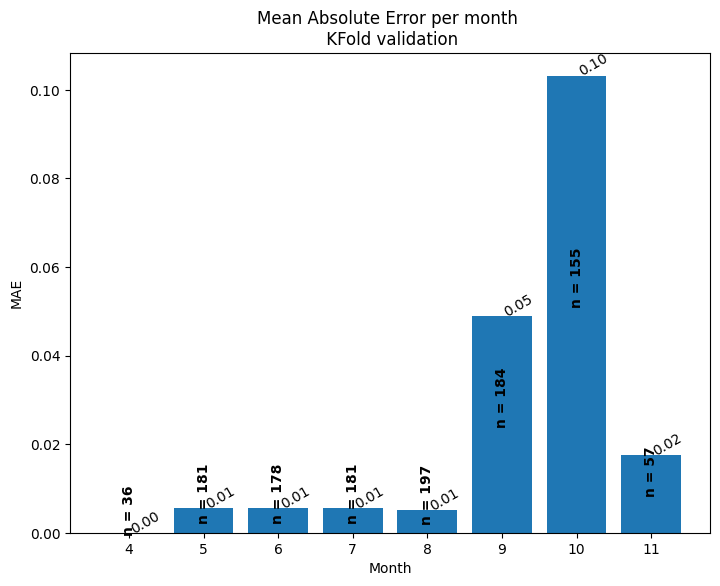

In [9]:
train_model_KFold(data, model, date_col=date_col)

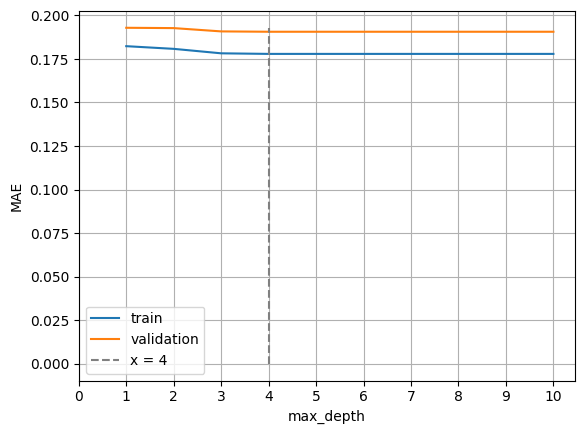

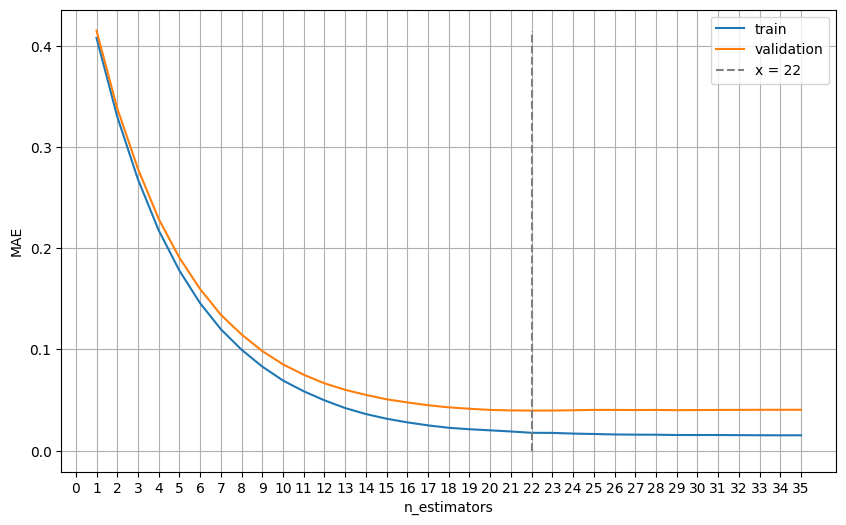

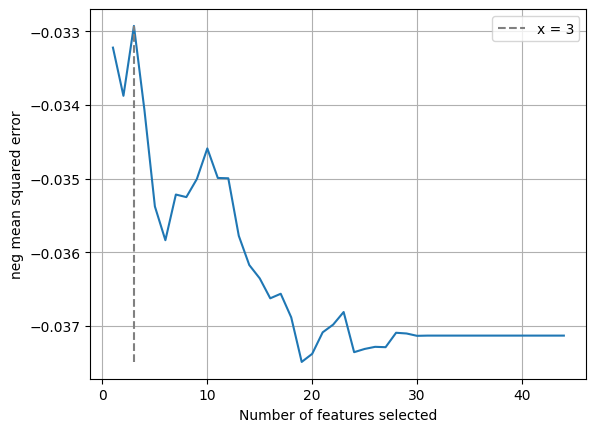

max_depth:  4
Number of estimators:  22
Selected_features:  Index(['ndvi', 'ndvi_std', 'ndmi_std'], dtype='object')
2021
MAE on train set:  0.010931768158473954
min prediction: 0.0
max prediction: 2.0

MAE on test set:  0.052980132450331126
Error <= 3: 100.00 %
min prediction: 0.0
max prediction: 0.0


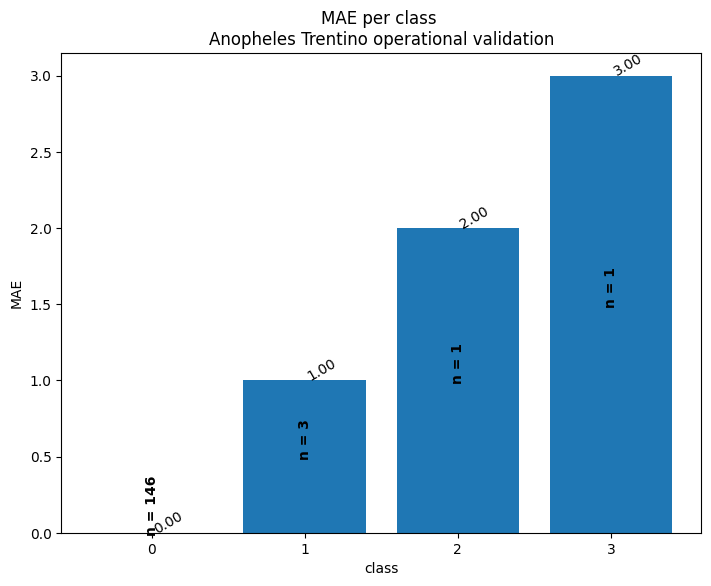

-----------|class error-MAE| difference-----------
mean: 1.5
std: 1.118033988749895
coefficient of variation (std/mean): 0.7453559924999299

----------normalized difference-------------
mean: 0.49999999999999994
std: 0.37267799624996495
coefficient of variation (std/mean): 0.74535599249993


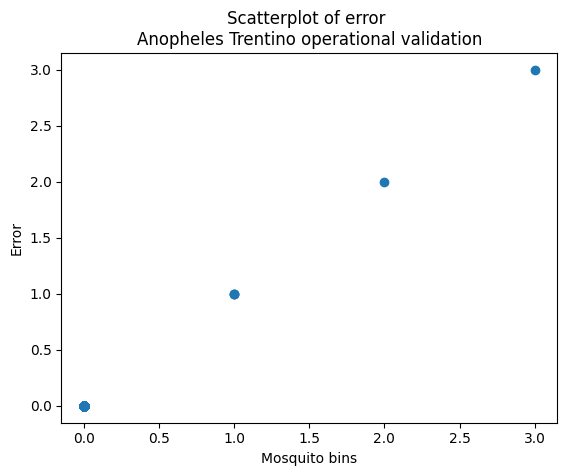

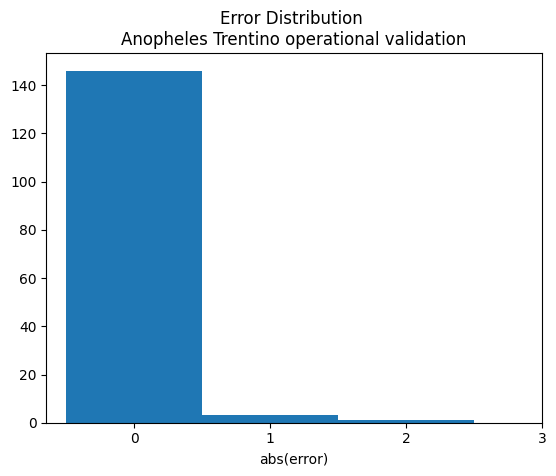

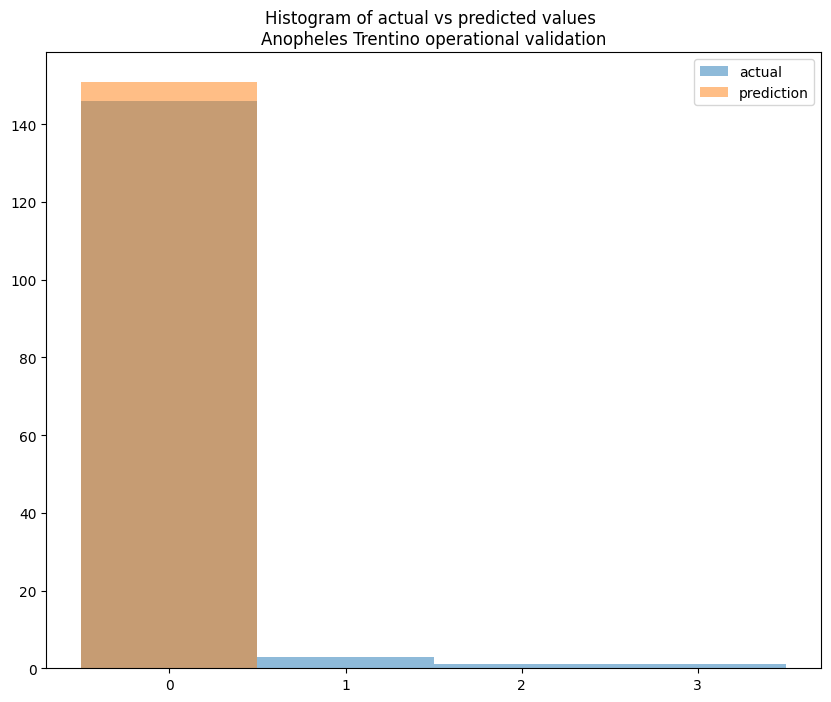

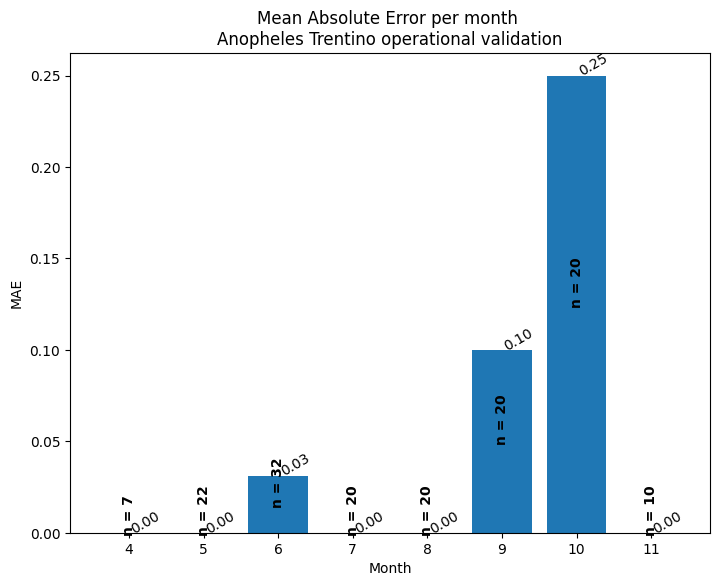

2022
MAE on train set:  0.010931768158473954
min prediction: 0.0
max prediction: 2.0

MAE on test set:  0.021052631578947368
Error <= 3: 100.00 %
min prediction: 0.0
max prediction: 0.0


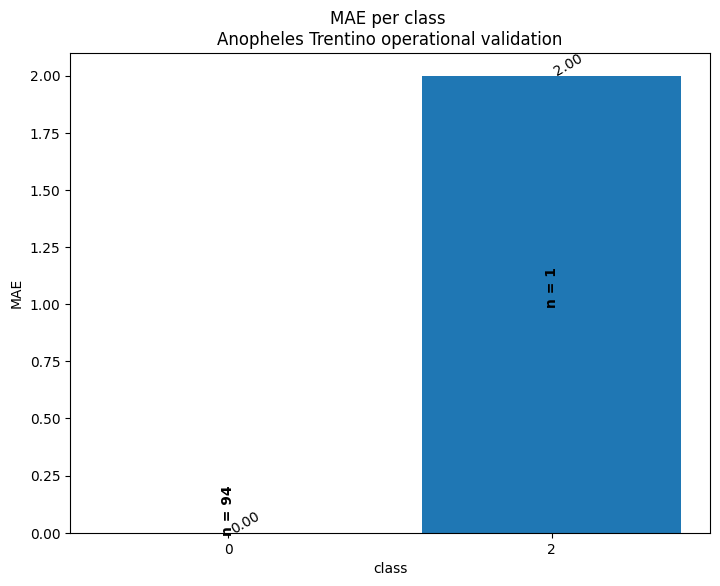

-----------|class error-MAE| difference-----------
mean: 1.0
std: 1.0
coefficient of variation (std/mean): 1.0

----------normalized difference-------------
mean: 0.5
std: 0.5
coefficient of variation (std/mean): 1.0


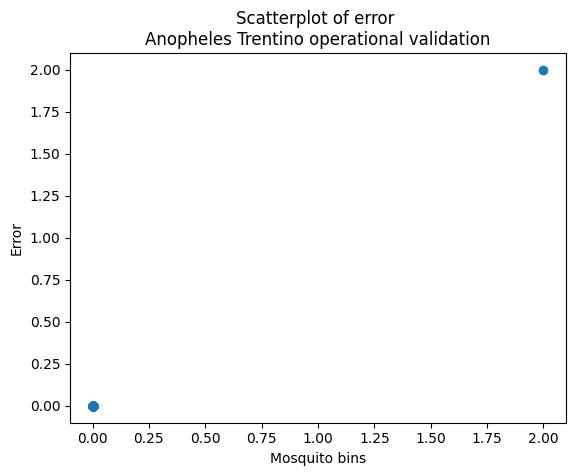

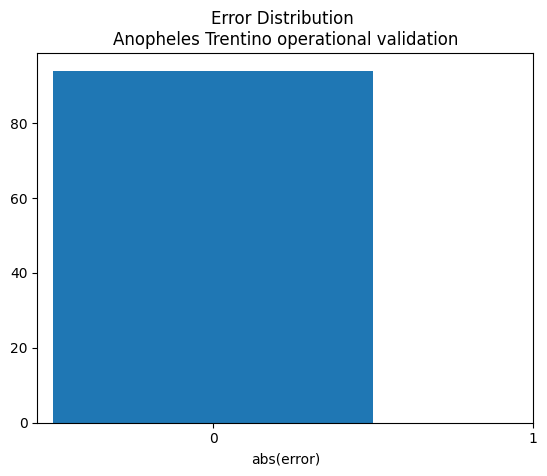

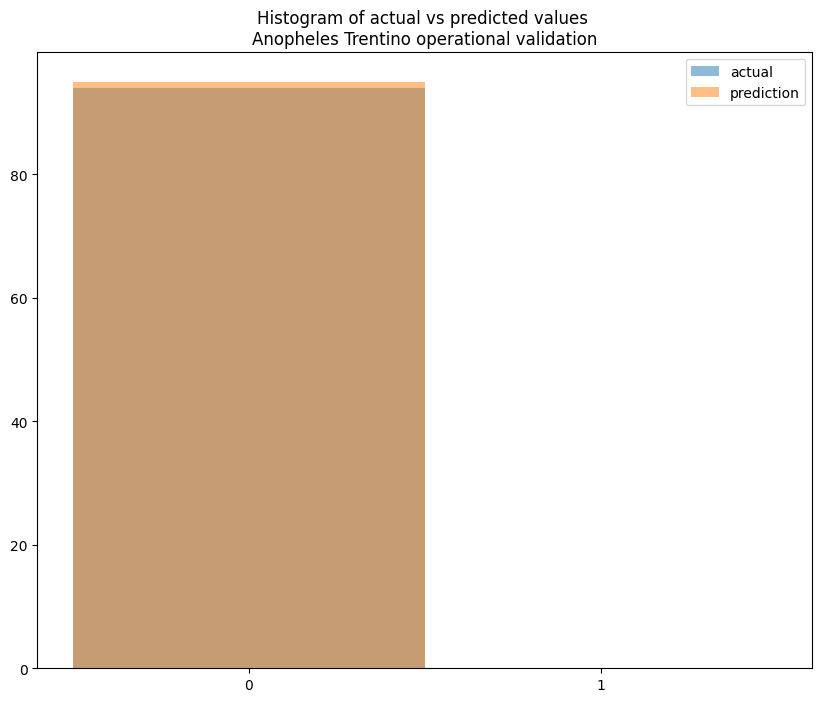

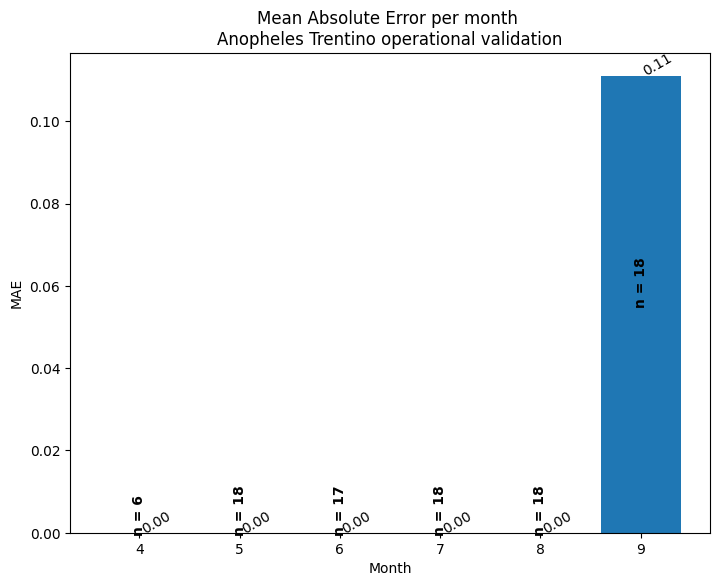

In [10]:
operational_validation(data, model, filepath = path, date_col = date_col,
                       date = '2021-01-01', case = case_title, export= exp)